In [1]:
import numpy as np
import scipy

In [2]:
n = 512
t = 2.5*np.linspace(-1,1,n)[:,None]
# y = np.sin(10*2*np.pi*t)*(1/(0.5*np.sqrt(2*np.pi)))*np.exp(-(0.5)*np.abs(t)**2/0.5**2)
# y = (1/(0.5*np.sqrt(2*np.pi)))*np.exp(-(0.5)*np.abs(t)**2/0.5**2)
# y = np.where(abs(t)<=0.5, 1, 0)
numberOfBasis = 5

c = [-1, 1, -0.5, 1.2, -1.5]
l = [0.1, 0.2, 0.4, 0.2, 0.2]

y = np.zeros_like(t)
for i in range(numberOfBasis):
    y += 1/(l[i]*np.sqrt(2*np.pi))*np.exp(-(t-c[i])**2/(2*l[i]**2))
#     y += np.exp(-(t-c[i])**2/(2*l[i]**2))

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

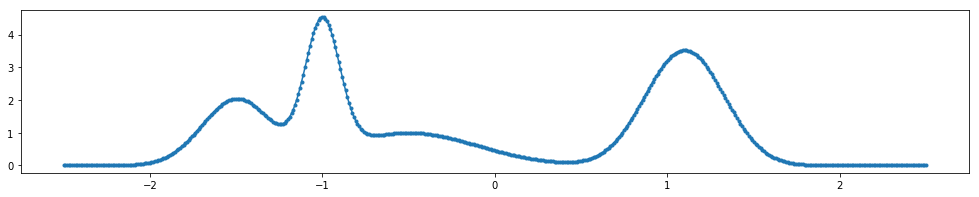

In [4]:
plt.figure(figsize=(17,3))
plt.plot(t,y,'.-')

In [5]:
# f(t) = 1/(l*sqrt(2pi)) exp(-(t-c)**2/(2l**2))
def gaussian_ft(w, l, c):
    return 1/np.sqrt(2*np.pi)*np.exp(-1.0/2.0*(2*np.pi*w*l)**2) * np.exp(1j*c*2*np.pi*w)

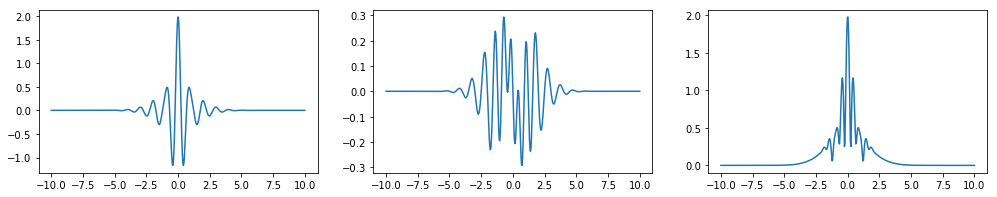

In [6]:
from scipy.fftpack import fft
dt = t[1]-t[0]
fs = 1/dt

n_fft = n

f = (fs/2)*np.arange(-1, 1, 2/n_fft)[:,None]
# w = f
w = np.linspace(-10,10,n_fft)[:,None]
y_fft = np.zeros_like(w, dtype=np.complex128)
y_fft_scaled = np.zeros_like(w, dtype=np.complex128)

# print(y_fft.shape)
for i in range(numberOfBasis):
    y_fft += gaussian_ft(w,l[i],c[i])
    y_fft_scaled += gaussian_ft(f,l[i],c[i])
y_fft = y_fft.reshape(-1)
y_fft_scaled = y_fft_scaled.reshape(-1)
# frequencies = np.fft.fftshift(frequencies)[:,None]
# frequencies  = frequencies - np.mean(frequencies)

fig, ax = plt.subplots(1,3, figsize=(17,3))
ax[0].plot(w, y_fft.real, '-')
# ax[0].set_xlim([-50,50])
ax[1].plot(w, y_fft.imag, '-')
# ax[1].set_xlim([-50,50])
ax[2].plot(w,np.abs(y_fft), '-')
# ax[2].set_xlim([-50,50])

In [27]:
np.random.seed(42)
n_obs = np.ceil(0.2*n_fft).astype('int')
index_obs = np.sort(np.random.choice(np.arange(n_fft), size=n_obs, replace=False))
w_obs = w[index_obs]
y_fft_obs = y_fft[index_obs]
sigma_noise = 0.001
y_fft_obs.real = y_fft_obs.real + sigma_noise*np.random.randn(n_obs)
y_fft_obs.imag = y_fft_obs.imag + sigma_noise*np.random.randn(n_obs)

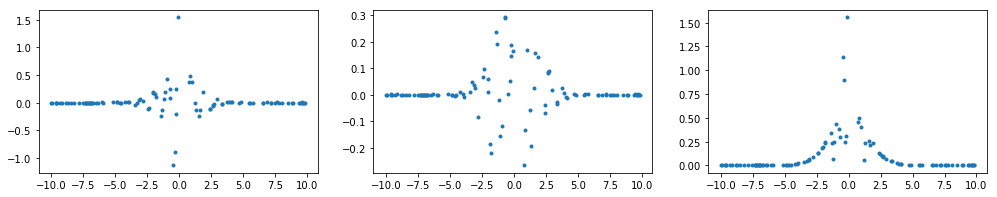

In [28]:
fig, ax = plt.subplots(1,3, figsize=(17,3))
ax[0].plot(w_obs, y_fft_obs.real, '.')
# ax[0].set_xlim([-20,20])
ax[1].plot(w_obs, y_fft_obs.imag , '.')
# ax[1].set_xlim([-20,20])
ax[2].plot(w_obs, np.abs(y_fft_obs),'.')
# ax[2].set_xlim([-20,20])

In [29]:
import gpflow

In [30]:
isJointcase = True
isNoiseVarianceTrainable = True

In [31]:
if isJointcase:
    k1 = gpflow.kernels.RBF(1)
#     k1 = gpflow.kernels.Matern12(1)
#     k1 = gpflow.kernels.Matern52(1)
    # k1 = gpflow.kernels.Matern32(1)
#     k3 = gpflow.kernels.Periodic(1)

#     k2 = gpflow.kernels.Cosine(1)
#     k3 = gpflow.kernels.Cosine(1)


    k = gpflow.kernels.RBF(1)*gpflow.kernels.Cosine(1)
    
#     for i in range(numberOfBasis-1):
#         k += gpflow.kernels.RBF(1)*gpflow.kernels.Cosine(1)
    
    coreg = gpflow.kernels.Coregion(1, output_dim=2, rank=1, active_dims=[1])
    kern = k * coreg
#     #set data dimensions
#     INPUT_DIM = 1
#     N_OUTPUTS = 2
#     #Set the number of components
#     number_of_components = 2
#     kern = MOSM(INPUT_DIM, N_OUTPUTS)
#     for i in range(number_of_components-1):
#         kern += MOSM(INPUT_DIM, N_OUTPUTS)
    
else:
    k1 = gpflow.kernels.Matern12(1)
    # k1 = gpflow.kernels.Matern32(1)
    # k1 = gpflow.kernels.Matern52(1)
    # k1 = gpflow.kernels.RBF(1)
    k2 = gpflow.kernels.Periodic(1)
    kern = k1*k2


In [32]:
# # k1 = Rectangular()
# k1 = gpflow.kernels.Matern12(1)
# # k1 = gpflow.kernels.Matern32(1)
# # k1 = gpflow.kernels.Matern52(1)
# # k1 = gpflow.kernels.RBF(1)
# k2 = gpflow.kernels.Periodic(1)
# kern = k1*k2

In [33]:
y_fft_obs.real[:,None].shape

(103, 1)

In [34]:
if isJointcase:
    X = np.vstack([np.hstack( [w_obs, np.zeros_like(w_obs)] ),
                   np.hstack( [w_obs, np.ones_like(w_obs) ] )])
    Y = np.vstack([np.hstack( [y_fft_obs.real[:,None], np.zeros_like(w_obs)]),
                   np.hstack( [y_fft_obs.imag[:,None], np.ones_like(w_obs)]) ])

else:
    X = w_obs
    Y = y_fft_obs.real[:,None]
print('Y:')
print(Y)

print('X:')
print(X)

Y:
[[ 2.80992935e-04  0.00000000e+00]
 [-6.22698240e-04  0.00000000e+00]
 [-2.08124757e-04  0.00000000e+00]
 [-4.93004702e-04  0.00000000e+00]
 [-5.89369859e-04  0.00000000e+00]
 [ 8.49597693e-04  0.00000000e+00]
 [ 3.57033224e-04  0.00000000e+00]
 [-6.92871162e-04  0.00000000e+00]
 [ 8.99567375e-04  0.00000000e+00]
 [ 3.07024342e-04  0.00000000e+00]
 [ 8.13076151e-04  0.00000000e+00]
 [ 6.30833648e-04  0.00000000e+00]
 [-8.34298177e-04  0.00000000e+00]
 [-5.65273308e-04  0.00000000e+00]
 [ 7.43995144e-04  0.00000000e+00]
 [ 6.09590869e-04  0.00000000e+00]
 [-1.46430420e-05  0.00000000e+00]
 [ 1.27845764e-04  0.00000000e+00]
 [ 1.30079414e-03  0.00000000e+00]
 [-5.65561677e-04  0.00000000e+00]
 [ 5.74583291e-04  0.00000000e+00]
 [-1.75089185e-04  0.00000000e+00]
 [-2.06462953e-04  0.00000000e+00]
 [ 1.08593558e-03  0.00000000e+00]
 [ 7.25495810e-04  0.00000000e+00]
 [ 7.26830044e-04  0.00000000e+00]
 [ 1.58542064e-03  0.00000000e+00]
 [ 3.69980675e-04  0.00000000e+00]
 [ 1.97369792e-03

In [35]:
if isJointcase:
    lik = gpflow.likelihoods.SwitchedLikelihood([gpflow.likelihoods.Gaussian(), gpflow.likelihoods.Gaussian()])
else:
    lik = gpflow.likelihoods.Gaussian()

In [36]:
m = gpflow.models.VGP(X, Y, kern=kern, likelihood=lik, num_latent=1)

if isJointcase:
    m.likelihood.likelihood_list[0].variance = sigma_noise**2
    m.likelihood.likelihood_list[1].variance = sigma_noise**2
    
    if not isNoiseVarianceTrainable:
        m.likelihood.likelihood_list[0].variance.trainable = False
        m.likelihood.likelihood_list[1].variance.trainable = False
else:
    m.likelihood.variance = 1
    
    if not isNoiseVarianceTrainable:
        m.likelihood.variance.trainable = False

opt = gpflow.train.AdamOptimizer()
opt.minimize(m, maxiter=100000)

/home/lerko/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [37]:
m.kern.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
VGP/kern/kernels/0/variance,Parameter,None,+ve,True,(),True,0.2935217819655247
VGP/kern/kernels/0/lengthscales,Parameter,None,+ve,True,(),True,0.5317771254924806
VGP/kern/kernels/1/variance,Parameter,None,+ve,True,(),True,0.2935217819651832
VGP/kern/kernels/1/lengthscales,Parameter,None,+ve,True,(),True,0.1541825042567359
VGP/kern/kernels/2/W,Parameter,None,(none),True,"(2, 1)",True,"[[0.0], [0.0]]"
VGP/kern/kernels/2/kappa,Parameter,None,+ve,True,"(2,)",True,"[0.6637572901032361, 0.16770000938094257]"


In [38]:
# m.kern.kernels[0].lengthscales

In [39]:
m.likelihood.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
VGP/likelihood/likelihood_list/0/variance,Parameter,None,+ve,True,(),True,1.00000000069789e-06
VGP/likelihood/likelihood_list/1/variance,Parameter,None,+ve,True,(),True,1.0000000007267498e-06


In [40]:
def plot_gp(x, mu, var, color='k', ax = None):
    ax.plot(x, mu, '+', color=color, lw=2)
    
    lower_bound = mu - 2*np.sqrt(var)
    upper_bound = mu + 2*np.sqrt(var)
    print(x.shape)
    print(lower_bound.shape)
    print(upper_bound.shape)
    ax.fill_between(x.reshape(-1), lower_bound[:,0].reshape(-1), upper_bound[:,0].reshape(-1) , color=color, alpha=0.3)

def plot(mu, var, X = w_obs, Y = y_fft_obs.real, fig=None , ax=None, str_title=None): 
    line, = ax.plot(X, Y, 'x', mew=2)
    plot_gp(w, mu, var, line.get_color(), ax=ax)
    
    if not str_title is None:
        ax.set_title(str_title)
    ax.legend(['Real spectrum', 'Observation', 'Estimation'])

(512, 1)
(512, 1)
(512, 1)
(512, 1)
(512, 1)
(512, 1)


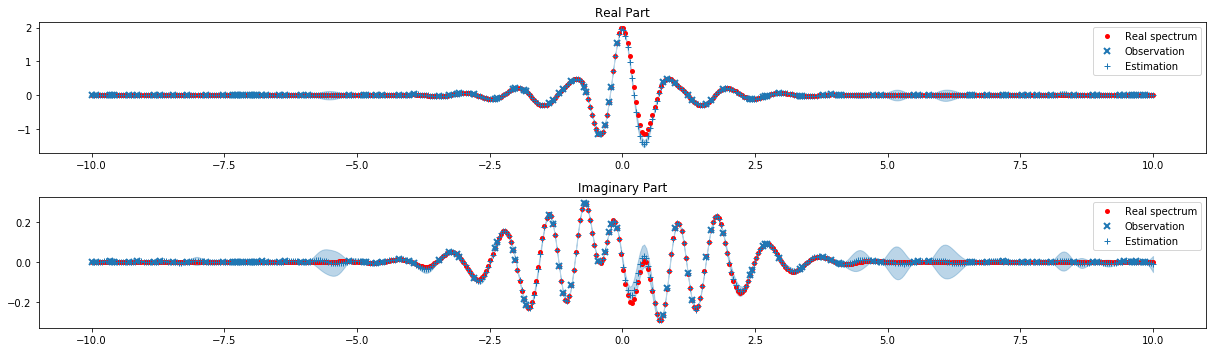

In [126]:
fig = plt.figure(figsize=(17,5))
ax = fig.add_subplot(211)
x1_augmented = np.hstack( [w, np.zeros_like(w)] )
mu_real, var_real = m.predict_f(x1_augmented)

plt.plot(w, y_fft.real, '.r', mew=2)
plot(mu_real,var_real, Y=y_fft_obs.real, fig=fig, ax=ax, str_title='Real Part')
# ax.set_xlim([-50,50])

ax = fig.add_subplot(212)
x2_augmented = np.hstack( [w, np.ones_like(w)] )
mu_imag, var_imag = m.predict_f(x2_augmented)

plt.plot(w, y_fft.imag, '.r', mew=2)
plot(mu_imag,var_imag, Y = y_fft_obs.imag, fig=fig, ax=ax, str_title='Imaginary Part')
# ax.set_xlim([-50,50])
fig.tight_layout()
fig.savefig('spectrum20.pdf', format='pdf')

In [42]:
import scipy as sp

In [46]:
F = sp.linalg.dft(n)
invF = sp.linalg.inv(F)

In [75]:
x1_scaled = np.hstack( [f, np.zeros_like(f)] )
x2_scaled = np.hstack( [f, np.ones_like(f)] )
x_augmented = np.concatenate((x1_scaled,x2_scaled))

numberOfSamplings = 20
S_ft_all= m.predict_f_samples(x_augmented,numberOfSamplings)
S_ft = S_ft_all[:,:f.shape[0],:]+1j*S_ft_all[:,f.shape[0]:,:]
S = np.abs(np.matmul(invF,S_ft[:,:,:]))

mu_scaled_real, var_scaled_real = m.predict_f(x1_scaled)
mu_scaled_imag, var_scaled_imag = m.predict_f(x2_scaled)

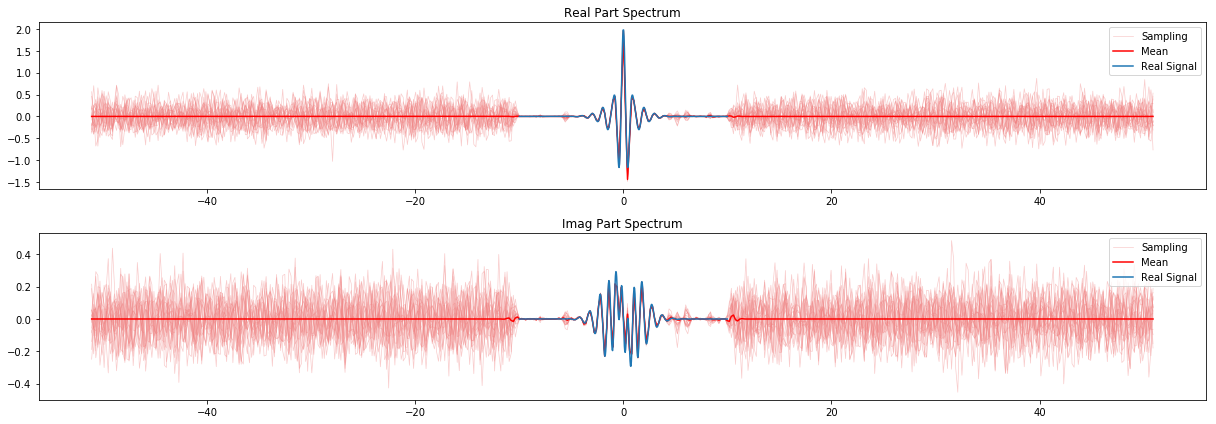

In [124]:
fig = plt.figure(figsize=(17,6))
ax = plt.subplot(211)
for i in range(numberOfSamplings-1):
    ax.plot(f,S_ft_all[i,:f.shape[0],:], 'lightcoral', linewidth = 0.7, alpha=0.4)
ax.plot(f,S_ft_all[-1,:f.shape[0],:], 'lightcoral', linewidth = 0.7, alpha=0.4, label='Sampling')
# plt.xlim([-15,15])

ax.plot(f, mu_scaled_real, 'r', label='Mean')
ax.plot(w,y_fft.real, label='Real Signal')
ax.legend(loc=1)
ax.set_title('Real Part Spectrum')

ax = plt.subplot(212)
for i in range(numberOfSamplings-1):
    ax.plot(f,S_ft_all[i,f.shape[0]:,:], 'lightcoral', linewidth = 0.7, alpha=0.4)
ax.plot(f,S_ft_all[-1,f.shape[0]:,:], 'lightcoral', linewidth = 0.7, alpha=0.4, label='Sampling')
# plt.xlim([-15,15])

ax.plot(f, mu_scaled_imag, 'r', label='Mean')
ax.plot(w,y_fft.imag, label='Real Signal')
ax.legend(loc=1)
ax.set_title('Imag Part Spectrum')
fig.tight_layout()
fig.savefig('Spectrum_estimation20.pdf', format='pdf')

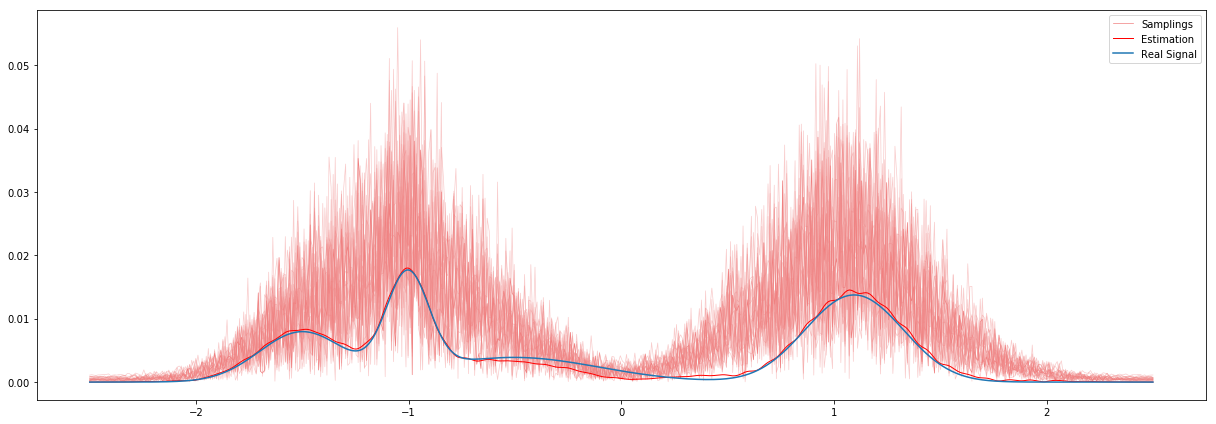

In [125]:
mu = mu_scaled_real+1j*mu_scaled_imag
var = var_scaled_real +1j*var_scaled_imag

fig = plt.figure(figsize=(17,6))
ax = plt.subplot(111)
y_hat = np.fft.fftshift(np.abs(np.matmul(invF,mu)))[::-1]
y_real = np.fft.fftshift(np.abs(np.matmul(invF,y_fft_scaled)))[::-1]

# plot_gp(f,y_hat,y_std, color='royalblue', ax=ax)

# y_real = np.matmul(invF,y_fft).real
for i in range(numberOfSamplings-1):
    ax.plot(t, np.fft.fftshift(S[i,:,:])[::-1],'lightcoral', linewidth = 0.7, alpha=0.4)
# plt.legend(['Samplings'])
ax.plot(t, np.fft.fftshift(S[-1,:,:])[::-1],'lightcoral', linewidth = 0.7, alpha=1, label='Samplings')
ax.plot(t,y_hat,'-', color='r', linewidth=1, label='Estimation', markersize=2)
ax.plot(t,y_real, label='Real Signal')
ax.legend()


# ax.set_xlim([-1.5,-1])
# plt.plot(t,S, alpha=0.3)
# plt.fill_between(t.reshape(-1), y_hat.reshape(-1), y_hat.reshape(-1)+2*np.sqrt(var_hat), y_hat.reshape(-1)-2*np.sqrt(var_hat), alpha=0.3)
# ax = plt.subplot(212)
# # ax.plot(t,y/250, label='Real Signal')
# ax.plot(t,y_real, label='Inverse Fourier Signal')
# ax.plot(t,y*np.max(y_real)/np.max(y), label='Signal')
# ax.legend()

fig.tight_layout()
fig.savefig('GP-reconstruction20.pdf', format='pdf')